In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as Cus_tkt_pd

Cus_tkt_input_path = "/cus_tkt_cleaned.csv"

Cus_tkt_dframe_final = Cus_tkt_pd.read_csv(Cus_tkt_input_path)
print("dataframe shape:", Cus_tkt_dframe_final.shape)
print("Columns:", Cus_tkt_dframe_final.columns.tolist())

print("\nClass distribution:")
print(Cus_tkt_dframe_final["type"].value_counts())

dataframe shape: (28261, 2)
Columns: ['text', 'type']

Class distribution:
type
1    11213
3     8163
2     5895
0     2990
Name: count, dtype: int64


Text Cleaning

In [ ]:
# Clean spaces
Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].str.strip().replace(r'\s+', ' ', regex=True)

In [ ]:
import re as Cus_tkt_re

Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].apply(lambda x: Cus_tkt_re.sub(r'[^a-zA-Z\s]', '', x))

In [ ]:
# Lowercase text
Cus_tkt_dframe_final["text"] = Cus_tkt_dframe_final["text"].str.lower()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize as Cus_tkt_word_tokn
from nltk.corpus import stopwords as Cus_tkt_stopwords_corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Tokenize
Cus_tkt_dframe_final["tokens"] = Cus_tkt_dframe_final["text"].apply(Cus_tkt_word_tokn)

In [ ]:
stop_words_en = set(stopwords.words('english'))

Cus_tkt_dframe_final["tokens"] = Cus_tkt_dframe_final["tokens"].apply(lambda tokens: [w for w in tokens if w not in stop_words_en])

In [ ]:
Cus_tkt_dframe_final

,text,type,tokens
0,account disruption dear customer support teamn...,1,"[account, disruption, dear, customer, support,..."
1,query about smart home system integration feat...,3,"[query, smart, home, system, integration, feat..."
2,inquiry regarding invoice details dear custome...,3,"[inquiry, regarding, invoice, details, dear, c..."
3,question about marketing agency software compa...,2,"[question, marketing, agency, software, compat..."
4,feature query dear customer supportnni hope th...,3,"[feature, query, dear, customer, supportnni, h..."
...,...,...,...
28256,guidelines for securing medical data in obs st...,3,"[guidelines, securing, medical, data, obs, stu..."
28257,can you provide information on digital strateg...,3,"[provide, information, digital, strategies, bo..."
28258,support for marketing enhancements request for...,0,"[support, marketing, enhancements, request, as..."
28259,assistance needed for ifttt docker integration...,2,"[assistance, needed, ifttt, docker, integratio..."


In [ ]:
from sklearn.model_selection import train_test_split as cus_tkt_split

# ipnput and output
cus_X_feat_tkt = Cus_tkt_dframe_final["tokens"]
cus_Y_out_tkt = Cus_tkt_dframe_final["type"]

# 80% train, 20% test
cus_Xin_tran, cus_Xin_tst, cus_Yin_tran, cus_Yin_tst = cus_tkt_split(cus_X_feat_tkt, cus_Y_out_tkt, test_size=0.2, random_state=42, stratify=cus_Y_out_tkt)
print("Train shape:", cus_Xin_tran.shape, "Test shape:", cus_Xin_tst.shape)

Train shape: (22608,) Test shape: (5653,)


In [ ]:
from transformers import RobertaTokenizer as cus_tkt_RTokn, RobertaModel as cus_tkt_RModel
import torch as cus_tkt_torch
import numpy as cus_tkt_nump

# Load RoBERTa base model and tokenizer
cus_tkt_roberta_tokn = cus_tkt_RTokn.from_pretrained('roberta-base')
cus_tkt_roberta_mdl = cus_tkt_RModel.from_pretrained('roberta-base')

# Function to generate RoBERTa embeddings
def get_roberta_vector(tokens, tokenizer, model, max_len=128):
    # Convert tokens back to text
    text = " ".join(tokens)

    # Tokenize for RoBERTa
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len
    )

    # Disable gradients
    with cus_tkt_torch.no_grad():
        outputs = model(**inputs)

    # Use CLS-like token embedding (<s> token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Create embeddings
cus_Xin_tran_vecroberta = cus_tkt_nump.array([
    get_roberta_vector(tokens, cus_tkt_roberta_tokn, cus_tkt_roberta_mdl)
    for tokens in cus_Xin_tran
])

cus_Xin_tst_vecroberta = cus_tkt_nump.array([
    get_roberta_vector(tokens, cus_tkt_roberta_tokn, cus_tkt_roberta_mdl)
    for tokens in cus_Xin_tst
])

print("Training shape RoBERTa embedded data:", cus_Xin_tran_vecroberta.shape,
      "Testing shape RoBERTa embedded data:", cus_Xin_tst_vecroberta.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training shape RoBERTa embedded data: (22608, 768) Training shape RoBERTa embedded data: (5653, 768)


SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE as Cus_tkt_SMT

# Apply SMOTE on training set
Cus_tkt_smote = Cus_tkt_SMT(random_state=42)
cus_Xin_tran_vecroberta_sm, cus_Yin_tran_sm = Cus_tkt_smote.fit_resample(cus_Xin_tran_vecroberta, cus_Yin_tran)

# Before SMOTE – class distribution
print("Before SMOTE — Train distribution:\n", cus_Yin_tran.value_counts())

# After SMOTE – class distribution
print("After SMOTE — Train distribution:\n", cus_Yin_tran_sm.value_counts())

Before SMOTE — Train distribution:
 type
1    8970
3    6530
2    4716
0    2392
Name: count, dtype: int64
After SMOTE — Train distribution:
 type
2    8970
1    8970
0    8970
3    8970
Name: count, dtype: int64


# **SVM with Various Kernels**

In [ ]:
import time as cus_tkt_timetakn
import matplotlib.pyplot as Cus_tkt_plot
import seaborn as Cus_tkt_seabn
from sklearn.svm import SVC as Cus_tkt_svm
from sklearn.model_selection import GridSearchCV as Cus_tkt_gridparam
from sklearn.metrics import classification_report as Cus_tkt_rp, accuracy_score as cus_tkt_acc, roc_auc_score as Cus_tkt_rocauc, confusion_matrix as Cus_tkt_cmatrix

**Linear SVM, RBF SVM and Polynomial SVM**


--- Linear SVM ---
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'C': 10}
Training time in sec: 1311.03
Training Accuracy: 0.8466
Testing Accuracy: 0.7858
Testing time in sec: 53.66

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       598
           1       0.79      0.68      0.73      2243
           2       0.52      0.65      0.58      1179
           3       0.97      0.98      0.98      1633

    accuracy                           0.79      5653
   macro avg       0.80      0.81      0.80      5653
weighted avg       0.80      0.79      0.79      5653



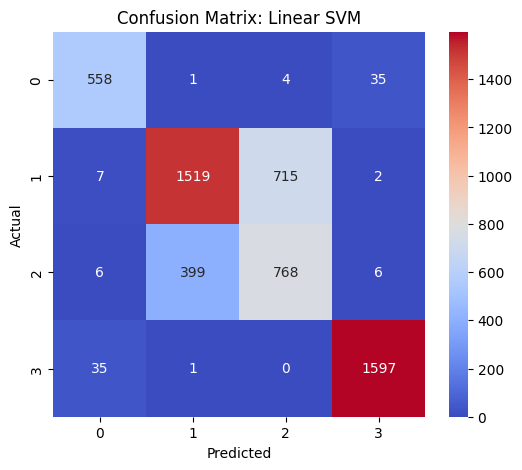

AU ROC Score: 0.9388

--- RBF SVM ---
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'C': 10, 'gamma': 'scale'}
Training time in sec: 2133.31
Training Accuracy: 0.8027
Testing Accuracy: 0.7614
Testing time in sec: 108.47

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       598
           1       0.78      0.61      0.69      2243
           2       0.48      0.66      0.56      1179
           3       0.96      0.98      0.97      1633

    accuracy                           0.76      5653
   macro avg       0.79      0.79      0.78      5653
weighted avg       0.79      0.76      0.77      5653



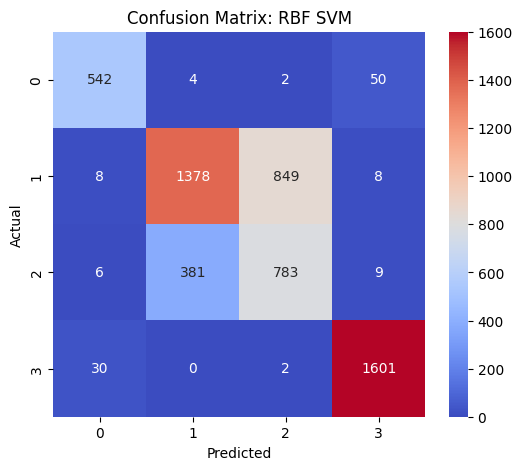

AU ROC Score: 0.9332

--- Polynomial SVM ---
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Parameters: {'C': 1}
Training time in sec: 3070.96
Training Accuracy: 0.7693
Testing Accuracy: 0.7447
Testing time in sec: 97.22

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       598
           1       0.75      0.63      0.68      2243
           2       0.46      0.59      0.51      1179
           3       0.95      0.97      0.96      1633

    accuracy                           0.74      5653
   macro avg       0.76      0.77      0.76      5653
weighted avg       0.76      0.74      0.75      5653



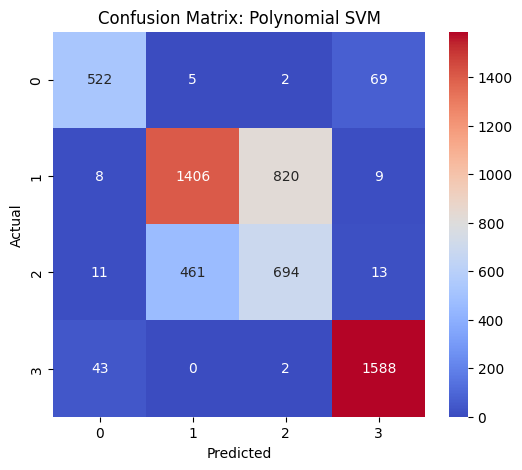

AU ROC Score: 0.9232


In [ ]:
#subset for hyperparameter tuning
Cus_sub_X = cus_Xin_tran_vecroberta_sm[:2000]
Cus_sub_y = cus_Yin_tran_sm[:2000]


Cus_tkt_diffsvm_md = {
    "Linear SVM": {
        "model": Cus_tkt_svm(kernel='linear', probability=True, random_state=42),
        "params": {"C": [1, 10]}
    },
    "RBF SVM": {
        "model": Cus_tkt_svm(kernel='rbf', probability=True, random_state=42),
        "params": {"C": [1, 10], "gamma": ["scale"]}
    },
    "Polynomial SVM": {
        "model": Cus_tkt_svm(kernel='poly', degree=3, probability=True, random_state=42),
        "params": {"C": [1]}
    }
}

for name, config in Cus_tkt_diffsvm_md.items():
    print(f"\n--- {name} ---")

    # GridSearchCV with 2-fold cross-validation
    Cus_gd_tkt = Cus_tkt_gridparam(config["model"], config["params"], cv=2, n_jobs=-1, verbose=1)

    Cus_tra_st = cus_tkt_timetakn.time()
    Cus_gd_tkt.fit(Cus_sub_X, Cus_sub_y)
    Cus_tra_en = cus_tkt_timetakn.time()

    Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st
    best_params = Cus_gd_tkt.best_params_

    print("Best Parameters:", best_params)

    #Training model with best parameters and full training data
    Cus_final_model = Cus_tkt_svm(
        kernel=config["model"].kernel,
        probability=True,
        random_state=42,
        **best_params
    )

    Cus_tra_st_full = cus_tkt_timetakn.time()
    Cus_final_model.fit(cus_Xin_tran_vecroberta_sm, cus_Yin_tran_sm)
    Cus_tra_en_full = cus_tkt_timetakn.time()
    Cus_tra_tm_tkn_full = Cus_tra_en_full - Cus_tra_st_full

    Cus_Ytra_pdt = Cus_final_model.predict(cus_Xin_tran_vecroberta_sm)
    Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

    print("Training time in sec:", round(Cus_tra_tm_tkn_full, 2))
    print("Training Accuracy:", round(Cus_tra_accuracy, 4))

    #Testing
    Cus_tst_st = cus_tkt_timetakn.time()
    Cus_Ytst_pdt = Cus_final_model.predict(cus_Xin_tst_vecroberta)
    Cus_tst_en = cus_tkt_timetakn.time()
    Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

    print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
    print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
    print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

    # Confusion matrix
    cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
    Cus_tkt_plot.figure(figsize=(6,5))
    Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='coolwarm')
    Cus_tkt_plot.title(f'Confusion Matrix: {name}')
    Cus_tkt_plot.xlabel('Predicted')
    Cus_tkt_plot.ylabel('Actual')
    Cus_tkt_plot.show()

    #AUC score
    Cus_Y_tkt_prb = Cus_final_model.predict_proba(cus_Xin_tst_vecroberta)
    au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
    print("AU ROC Score:", round(au_score, 4))

# **Multinomial Naive Bayes**

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}
Training time in sec: 4.71
Training Accuracy: 0.7204
Testing Accuracy: 0.7088
Testing time in sec: 0.02

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.64      0.83      0.72       598
           1       0.74      0.63      0.68      2243
           2       0.44      0.51      0.47      1179
           3       0.93      0.92      0.92      1633

    accuracy                           0.71      5653
   macro avg       0.69      0.72      0.70      5653
weighted avg       0.72      0.71      0.71      5653



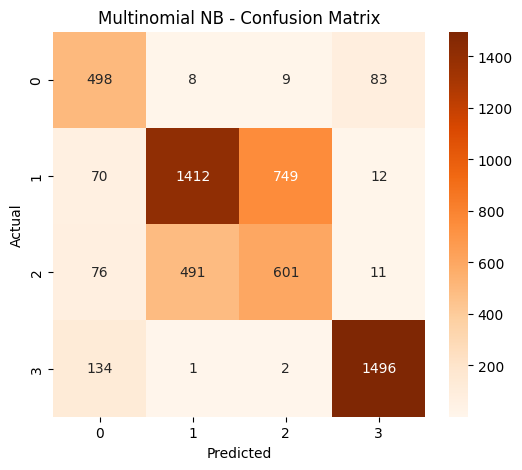

AUC Score: 0.9055


In [ ]:
from sklearn.naive_bayes import MultinomialNB as Cus_tkt_mnb
from sklearn.preprocessing import MinMaxScaler as Cus_tkt_mms

Cus_tkt_mnb_model = Cus_tkt_mnb()

Cus_tkt_mnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0],
    "fit_prior": [True, False],
    "class_prior": [None]
}

Cus_scale_r = Cus_tkt_mms()
cus_Xin_tran_vecw2v_scaled = Cus_scale_r.fit_transform(cus_Xin_tran_vecroberta_sm)
cus_Xin_tst_vecw2v_scaled = Cus_scale_r.transform(cus_Xin_tst_vecroberta)

# GridSearch
Cus_tkt_mnb_grid = Cus_tkt_gridparam(
    estimator=Cus_tkt_mnb_model,
    param_grid=Cus_tkt_mnb_param_grid,
    cv=2,
    n_jobs=-1,
    verbose=1
)

#Training
Cus_tra_st = cus_tkt_timetakn.time()
Cus_tkt_mnb_grid.fit(cus_Xin_tran_vecw2v_scaled, cus_Yin_tran_sm)
Cus_tra_en = cus_tkt_timetakn.time()
Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st

Cus_Ytra_pdt = Cus_tkt_mnb_grid.predict(cus_Xin_tran_vecw2v_scaled)
Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

print("Best Parameters:", Cus_tkt_mnb_grid.best_params_)
print("Training time in sec:", round(Cus_tra_tm_tkn, 2))
print("Training Accuracy:", round(Cus_tra_accuracy, 4))

# Testing
Cus_tst_st = cus_tkt_timetakn.time()
Cus_Ytst_pdt = Cus_tkt_mnb_grid.predict(cus_Xin_tst_vecw2v_scaled)
Cus_tst_en = cus_tkt_timetakn.time()

Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

# Confusion Matrix
cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
Cus_tkt_plot.figure(figsize=(6,5))
Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='Oranges')
Cus_tkt_plot.title("Multinomial NB - Confusion Matrix")
Cus_tkt_plot.xlabel('Predicted')
Cus_tkt_plot.ylabel('Actual')
Cus_tkt_plot.show()

# AUROC
Cus_Y_tkt_prb = Cus_tkt_mnb_grid.predict_proba(cus_Xin_tst_vecw2v_scaled)
au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
print("AUC Score:", round(au_score, 4))

# **Bernoulli Naive Bayes**

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best Parameters: {'alpha': 0.1, 'binarize': 0.0, 'fit_prior': True}
Training time in sec: 14.78
Training Accuracy: 0.7222
Testing Accuracy: 0.7062
Testing time in sec: 0.14

Testing prediction metrics:
               precision    recall  f1-score   support

           0       0.65      0.81      0.72       598
           1       0.74      0.62      0.67      2243
           2       0.44      0.52      0.48      1179
           3       0.93      0.92      0.92      1633

    accuracy                           0.71      5653
   macro avg       0.69      0.72      0.70      5653
weighted avg       0.72      0.71      0.71      5653



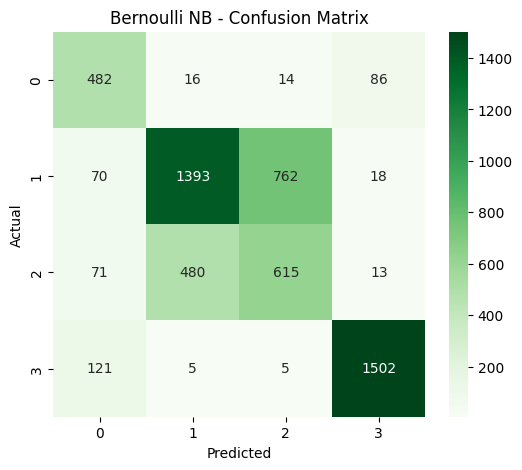

AUC Score: 0.9025


In [ ]:
from sklearn.naive_bayes import BernoulliNB as Cus_tkt_bnb

Cus_tkt_bnb_model = Cus_tkt_bnb()

Cus_tkt_bnb_param_grid = {
    "alpha": [0.1, 0.5, 1.0],
    "binarize": [0.0, 0.5, 1.0],
    "fit_prior": [True, False]
}

# GridSearch
Cus_tkt_bnb_grid = Cus_tkt_gridparam(
    estimator=Cus_tkt_bnb_model,
    param_grid=Cus_tkt_bnb_param_grid,
    cv=2,
    n_jobs=-1,
    verbose=1
)

# Training
Cus_tra_st = cus_tkt_timetakn.time()
Cus_tkt_bnb_grid.fit(cus_Xin_tran_vecroberta_sm, cus_Yin_tran_sm)
Cus_tra_en = cus_tkt_timetakn.time()
Cus_tra_tm_tkn = Cus_tra_en - Cus_tra_st


Cus_Ytra_pdt = Cus_tkt_bnb_grid.predict(cus_Xin_tran_vecroberta_sm)
Cus_tra_accuracy = cus_tkt_acc(cus_Yin_tran_sm, Cus_Ytra_pdt)

print("Best Parameters:", Cus_tkt_bnb_grid.best_params_)
print("Training time in sec:", round(Cus_tra_tm_tkn, 2))
print("Training Accuracy:", round(Cus_tra_accuracy, 4))

# Testing
Cus_tst_st = cus_tkt_timetakn.time()
Cus_Ytst_pdt = Cus_tkt_bnb_grid.predict(cus_Xin_tst_vecroberta)
Cus_tst_en = cus_tkt_timetakn.time()

Cus_tst_tm_tkn = Cus_tst_en - Cus_tst_st

print("Testing Accuracy:", round(cus_tkt_acc(cus_Yin_tst, Cus_Ytst_pdt), 4))
print("Testing time in sec:", round(Cus_tst_tm_tkn, 2))
print("\nTesting prediction metrics:\n", Cus_tkt_rp(cus_Yin_tst, Cus_Ytst_pdt))

# Confusion Matrix
cm_tkt_matrix = Cus_tkt_cmatrix(cus_Yin_tst, Cus_Ytst_pdt)
Cus_tkt_plot.figure(figsize=(6,5))
Cus_tkt_seabn.heatmap(cm_tkt_matrix, annot=True, fmt='d', cmap='Greens')
Cus_tkt_plot.title("Bernoulli NB - Confusion Matrix")
Cus_tkt_plot.xlabel('Predicted')
Cus_tkt_plot.ylabel('Actual')
Cus_tkt_plot.show()

# AUROC
Cus_Y_tkt_prb = Cus_tkt_bnb_grid.predict_proba(cus_Xin_tst_vecroberta)
au_score = Cus_tkt_rocauc(cus_Yin_tst, Cus_Y_tkt_prb, multi_class='ovr')
print("AUC Score:", round(au_score, 4))